In [11]:
## 导入库
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.quantization import QuantStub, DeQuantStub, quantize_dynamic
# from  auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig
import json
import random
import time
from awq import AutoAWQForCausalLM
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig


In [12]:
## 定义方法

def messages_to_prompt(messages, system_prompt='You are a helpful assistant.', fill_system_prompt=True):
    """
    将 messages 转换为 Qwen2 模型的输入 prompt。
    
    :param messages: 包含对话消息的列表，每个消息是一个字典，包含 'role' 和 'content' 字段。
                    例如: [{'role': 'system', 'content': 'You are a helpful assistant.'}, 
                          {'role': 'user', 'content': 'What is the capital of France?'}]
    :return: 转换后的 prompt 字符串，适用于 Qwen2 模型。
    """
    prompt = ""
    if fill_system_prompt and messages[0]['role'] != 'system':
        messages.insert(0, {'role': 'system', 'content': system_prompt})
    for message in messages:
        role = message['role']
        content = message['content']
        if role == 'system':
            prompt += f"<|im_start|>system\n{content}<|im_end|>\n"
        elif role == 'user':
            prompt += f"<|im_start|>user\n{content}<|im_end|>\n"
        elif role == 'assistant':
            prompt += f"<|im_start|>assistant\n{content}<|im_end|>\n"
        elif role == 'shipper':
            prompt += f"<|im_start|>shipper\n{content}<|im_end|>\n"
        elif role == 'knowledge':
            prompt += f"<|im_start|>knowledge\n{content}<|im_end|>\n"
        else:
            raise ValueError(f"Unknown role: {role}")
    
    # 添加 assistant 的开始标记，表示模型需要生成回复
    prompt += "<|im_start|>assistant\n"
    
    return prompt

In [16]:
## 制定模型路径和量化路径

model_path = "/root/LLMmodels/qwen/Qwen2___5-1___5B-Instruct"
output_path = "/root/matrix/LLM-Models-Export/huzhiqiang/量化"

### GPTQ( Post-Training Quantization for GPT Models)

**核心思想**
- 基于训练后量化（Post-Training Quantization），无需重新训练模型。
- 使用二阶梯度信息逐层优化权重，最小化量化误差。
- 通过Hessian矩阵（二阶导数）分析权重敏感性，动态调整量化策略。

**技术特点**
- 精度保留：通过逐层优化，保持模型性能接近原始精度。
- 硬件友好：支持GPU加速，适合需要快速推理的场景。
- 实现方式：将权重压缩为低精度（如4-bit/3-bit），同时保留少量高精度权重（如0.1%的异常值）。

***优点***
- 量化速度快，适合大模型快速部署。
- 在保持较高精度的同时显著减少模型体积（如LLaMA-65B从130GB压缩至约20GB）。

***缺点***
- 依赖GPU计算，对内存带宽要求较高。
- 量化过程需要一次性计算整个模型的Hessian矩阵，内存消耗大。

In [27]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

quant_path = output_path.join("/Qwen2.5-1.5B-Instruct-GPTQ")
# Specify paths and hyperparameters for quantization

quantize_config = BaseQuantizeConfig(
    bits=8, # 4 or 8
    group_size=32,
    damp_percent=0.01,
    desc_act=False,  # set to False can significantly speed up inference but the perplexity may slightly bad
    static_groups=False,
    sym=True,
    true_sequential=True,
    model_name_or_path=None,
    model_file_base_name="model"
)
max_len = 8192

# Load your tokenizer and model with AutoGPTQ
# To learn about loading model to multiple GPUs,
# visit https://github.com/AutoGPTQ/AutoGPTQ/blob/main/docs/tutorial/02-Advanced-Model-Loading-and-Best-Practice.md
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoGPTQForCausalLM.from_pretrained(model_path, quantize_config).cuda()
print(next(model.parameters()).device)


cuda:0


In [28]:
## 准备评测数据

file_path = '/root/matrix/LLM-Models-Export/guorui/训练集检查/车辆匹配sft.json'
messages = json.load(open(file_path, 'r',encoding='UTF-8'))

print('len(messages):',len(messages))
random.shuffle(messages)
messages = messages[:500]
print('len(messages):',len(messages))

data = []
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for msg in messages:
    text = messages_to_prompt(msg)
    model_inputs = tokenizer([text])
    input_ids = torch.tensor(model_inputs.input_ids[:max_len], dtype=torch.int, device="cpu")
    data.append(dict(input_ids=input_ids, attention_mask= input_ids.ne(tokenizer.pad_token_id)))
    # data.append(text.strip())
print('len(data):', len(data))


len(messages): 2664
len(messages): 500
True
len(data): 500


In [29]:
print(data[0]["input_ids"].device)
print(data[0]["attention_mask"].device)

cpu
cpu


In [30]:
import logging

logging.basicConfig(
    format="%(asctime)s %(levelname)s [%(name)s] %(message)s", level=logging.INFO, datefmt="%Y-%m-%d %H:%M:%S"
)

model.quantize(data)

model.save_quantized(quant_path, use_safetensors=True)                                    ## 保存量化模型
tokenizer.save_pretrained(quant_path)
# t2 = time.time()
# print(('time:{:.2f}s').format(t2-t1))

INFO - Start quantizing layer 1/28
2025-04-24 14:10:21 INFO [auto_gptq.modeling._base] Start quantizing layer 1/28
INFO - Quantizing self_attn.k_proj in layer 1/28...
2025-04-24 14:10:22 INFO [auto_gptq.modeling._base] Quantizing self_attn.k_proj in layer 1/28...
2025-04-24 14:10:22 INFO [auto_gptq.quantization.gptq] duration: 0.4511375427246094
2025-04-24 14:10:22 INFO [auto_gptq.quantization.gptq] avg loss: 0.003265141725540161
INFO - Quantizing self_attn.v_proj in layer 1/28...
2025-04-24 14:10:22 INFO [auto_gptq.modeling._base] Quantizing self_attn.v_proj in layer 1/28...
2025-04-24 14:10:23 INFO [auto_gptq.quantization.gptq] duration: 0.4150867462158203
2025-04-24 14:10:23 INFO [auto_gptq.quantization.gptq] avg loss: 0.00040165609121322633
INFO - Quantizing self_attn.q_proj in layer 1/28...
2025-04-24 14:10:23 INFO [auto_gptq.modeling._base] Quantizing self_attn.q_proj in layer 1/28...
2025-04-24 14:10:23 INFO [auto_gptq.quantization.gptq] duration: 0.41724157333374023
2025-04-24 

('//root/matrix/LLM-Models-Export/huzhiqiang/量化Q/root/matrix/LLM-Models-Export/huzhiqiang/量化w/root/matrix/LLM-Models-Export/huzhiqiang/量化e/root/matrix/LLM-Models-Export/huzhiqiang/量化n/root/matrix/LLM-Models-Export/huzhiqiang/量化2/root/matrix/LLM-Models-Export/huzhiqiang/量化./root/matrix/LLM-Models-Export/huzhiqiang/量化5/root/matrix/LLM-Models-Export/huzhiqiang/量化-/root/matrix/LLM-Models-Export/huzhiqiang/量化1/root/matrix/LLM-Models-Export/huzhiqiang/量化./root/matrix/LLM-Models-Export/huzhiqiang/量化5/root/matrix/LLM-Models-Export/huzhiqiang/量化B/root/matrix/LLM-Models-Export/huzhiqiang/量化-/root/matrix/LLM-Models-Export/huzhiqiang/量化I/root/matrix/LLM-Models-Export/huzhiqiang/量化n/root/matrix/LLM-Models-Export/huzhiqiang/量化s/root/matrix/LLM-Models-Export/huzhiqiang/量化t/root/matrix/LLM-Models-Export/huzhiqiang/量化r/root/matrix/LLM-Models-Export/huzhiqiang/量化u/root/matrix/LLM-Models-Export/huzhiqiang/量化c/root/matrix/LLM-Models-Export/huzhiqiang/量化t/root/matrix/LLM-Models-Export/huzhiqiang/量化-/root/m

### GGUF(GPT-Generated Unified Format)

**核心思想**
- 由llama.cpp社区提出的统一模型格式，专为量化模型设计。
- 目标是解决旧版GGML格式的兼容性问题，支持更灵活的量化策略和跨平台部署。

**技术特点**
- 跨平台支持：兼容CPU/GPU推理，优化Apple Silicon和CUDA加速。
- 元数据扩展：支持在模型文件中嵌入超参数、提示词模板等信息。
- 量化粒度：支持多种位宽（如Q4_K、Q5_K），混合精度量化不同层。

***优点***
- 轻量级依赖，适合边缘设备（如手机、嵌入式设备）。
- 量化模型可直接加载，无需额外转换步骤。
- 社区支持广泛，适配大多数开源大模型（如Llama、Mistral）。

***缺点***
- 量化精度略低于GPTQ/AWQ。
- 主要依赖CPU推理，GPU加速能力有限。

In [ ]:

# model_name = "Qwen"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path)

# 打印原始模型的大小
print(f"Original model size: {model.num_parameters()} parameters")

# 模型准备：将全局所有层量化（使用动态量化）
quantized_model = quantize_dynamic(
    model,  # 要量化的模型
    {torch.nn.Linear},  # 量化哪些层（这里是线性层）
    dtype=torch.qint8  # 量化数据类型，这里使用 8-bit 量化
)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


Original model size: 7615616512 parameters


In [ ]:
t1 = time.time()
model.quantize(tokenizer, quant_config=quant_config, calib_data=data,max_calib_seq_len=4000)            ## 数据校准
model.save_quantized(quant_path, safetensors=True, shard_size="4GB")                                    ## 保存量化模型
tokenizer.save_pretrained(quant_path)
t2 = time.time()
print(('time:{:.2f}s').format(t2-t1))

### AWQ

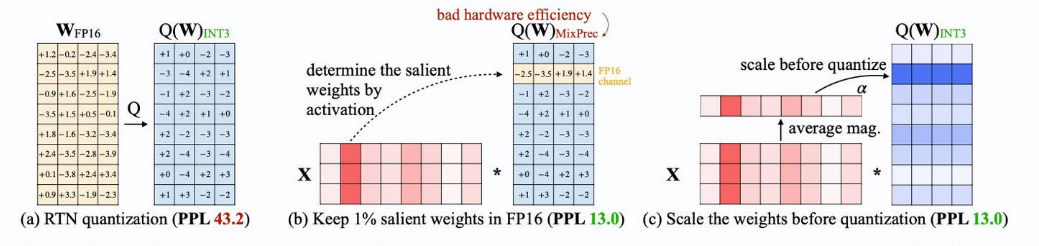

激活感知权重量化 (AWQ)，是一种用于 LLM 低位权重压缩的简便有效方法。基于权重在 LLM 中重要性不均的观察，AWQ 采用逐通道缩放来减少关键权重的量化损失。AWQ 不会对校准集过拟合，并能够保留 LLM 在不同领域和模态中的通用能力。它在语言建模方面优于现有方法，并可应用于指令微调的语言模型和多模态语言模型。和 Huggingface 的 FP16 实现相比，作者实现的 TinyChat 系统进一步将 AWQ 实现的内存节省转化为 $3.2-3.3$ 倍的实际加速效果。

**核心思想**
- 激活感知量化：根据权重在激活分布中的重要性动态调整量化策略。
- 保护关键权重（如1%的显著权重）为高精度，其余权重低比特量化。

**技术特点**
- 混合精度：对重要权重保留FP16，其他权重压缩至4-bit/3-bit。
- 零依赖校准：无需反向传播或梯度计算，仅通过前向分析激活值。
- 硬件适配：支持TensorCore加速（如NVIDIA GPU），优化计算效率。

***优点***
- 量化后模型精度损失极小（<1%）。
- 推理速度与FP16模型接近，显著优于传统量化方法。

***缺点***
- 量化过程需要少量校准数据（约128样本）。
- 实现复杂度较高，依赖专用推理引擎（如TensorRT-LLM）。

In [ ]:
quant_path = output_path.join("/Qwen2.5-7B-Insturct-AQW")
# Specify paths and hyperparameters for quantization
quant_config = { "zero_point": True, "q_group_size": 128, "w_bit": 4, "version": "GEMM"}

# Load your tokenizer and model with AutoAWQ
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoAWQForCausalLM.from_pretrained(model_path,
                                           device_map="cuda", 
                                           safetensors=True,
                                           torch_dtype='auto')


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


In [ ]:
## 准备评测数据

file_path = '/root/matrix/LLM-Models-Export/guorui/训练集检查/车辆匹配sft.json'
messages = json.load(open(file_path, 'r',encoding='UTF-8'))

print('len(messages):',len(messages))
random.shuffle(messages)
messages = messages[:500]
print('len(messages):',len(messages))

data = []
for msg in messages:
    text = messages_to_prompt(msg)
    data.append(text.strip())
print('len(data):',len(data))

In [11]:
t1 = time.time()
model.quantize(tokenizer, quant_config=quant_config, calib_data=data, max_calib_seq_len=4000)            ## 数据校准
model.save_quantized(quant_path, safetensors=True, shard_size="4GB")                                    ## 保存量化模型
tokenizer.save_pretrained(quant_path)
t2 = time.time()
print(('time:{:.2f}s').format(t2-t1))

AWQ: 100%|██████████| 28/28 [17:11<00:00, 36.83s/it]


time:1040.45s
